In [1]:
#Fundamentals
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import random
import math

#System
import os
import glob
import time
import multiprocessing as mp
import gc

#Pytorch
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

#Sklearn
from sklearn.model_selection import train_test_split

## Settings

In [2]:
folder="/mnt/idms/PROJECTS/Lung/LungCT/Super-resolution"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
number_of_epochs = 80
learning_rate = 0.05
batch_size=16

## Reading of input data

In [18]:
def create_triplets_from_case(case_path, idx):
    """
    Ideas for improvement:
    -Why do we have to double the number of slices? Couldn't we predict not 1, but more in-between?
    -Why to take just the neighbouring ones?
    -Now the triplets are (1,2,3),(4,5,6),(7,8,9)..., but could get more triplets by (1,2,3), (2,3,4), (3,4,5)...
    """
    npz=np.load(case_path)
    ct=npz[npz.files[0]]
    ct=np.moveaxis(ct,-1,0)
    ct=ct[:(len(ct)-(len(ct)%3))]
    case_triplets=np.asarray(np.split(ct,len(ct)//3))
    case_triplets=(case_triplets-np.min(case_triplets))/(np.max(case_triplets)-np.min(case_triplets))
    print(f"Case {idx+1} is done")
    return case_triplets
    
def create_all_triplets(parallel_jobs=mp.cpu_count(), max_cases=None):#, save=False):
    ct_path="/mnt/idms/PROJECTS/Lung/Tudo-Ulyssys-Unzipped"
    case_paths=list(glob.glob(f'{ct_path}/*/*.npz'))
    if max_cases:
        case_paths=case_paths[:max_cases]
    with mp.Pool(parallel_jobs) as pool: #get_context("spawn")
        triplets = pool.starmap(create_triplets_from_case, zip(case_paths,list(range(len(case_paths)))))
    pool.join() #Maybe helps

    """if save:
        with h5py.File(f"{folder}/data/input_data.h5", 'w') as h5f:
            h5f.create_dataset('triplets_per_patients', data=np.asarray(triplets))#, dtype=object))
    """
    return triplets

In [ ]:
%%time
triplets=create_all_triplets(max_cases=5, parallel_jobs=5) #VEEEERY SLOW WITH MORE MAX_CASES, 5000 DOESN'T EVEN RUN
#I COULDN'T FIND THE EXACT CAUSE, BUT IT CAN DEADLOCK WITH TOO MANY PARALLEL_JOBS AND MAX_CASES

Case 3 is done
Case 5 is done
Case 4 is done
Case 2 is done
Case 1 is done


## Dataloaders

In [11]:
class Triplets(Dataset):
    
    def __init__(self, data, triplets_per_case=20, transform=None):
        self.data = []
        self.len=len(data)*triplets_per_case
        for case in data:
            self.data+=list(case[np.random.choice(case.shape[0], triplets_per_case, replace=False),:,:,:])
        self.data=np.asarray(self.data)
        self.transform = transform
            
        
    def __getitem__(self, idx):
        xs=(self.data[idx,0,:,:],self.data[idx,2,:,:])
        y=self.data[idx,1,:,:]
        if self.transform:
            xs=tuple(self.transform(x) for x in xs)
            y=self.transform(y)
        return xs, y
    
    def __len__ (self):
        return self.len

In [12]:
train_transform = transforms.Compose([ #Now composition is unnecessary, but maybe more transforms will be added
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])
    
train_dataset_raw, test_dataset_raw = train_test_split(triplets, test_size=0.2, shuffle=True)
    
train_dataset = Triplets(train_dataset_raw, transform=train_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    
test_dataset = Triplets(test_dataset_raw, transform=test_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

## Neural network

In [13]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 9, padding = 4)
        self.conv2 = nn.Conv2d(64, 32, 1, padding = 0)
        self.conv3 = nn.Conv2d(32, 32, 5, padding = 2)
        self.conv4 = nn.Conv2d(32, 1, 1, padding = 0)
        
    def forward(self, x1, x3):
        x1 = F.selu(self.conv1(x1))
        x1 = F.selu(self.conv2(x1))
        x1 = F.selu(self.conv3(x1))
        x3 = F.selu(self.conv1(x3))
        x3 = F.selu(self.conv2(x3))
        x3 = F.selu(self.conv3(x3))
        out = torch.cat((x1, x3), dim=1)
        out = F.selu(self.conv2(out))
        out = F.selu(self.conv3(out))
        out = F.selu(self.conv4(out))
        return out

## Training

In [14]:
def train_step(model,device,optimizer,criterion,train_loader, log_freq=5):
    
    for batch_idx, (xs, ys) in enumerate(train_loader):
        xs=[x.to(device, dtype=torch.float) for x in xs]
        ys=ys.to(device, dtype=torch.float)
        outputs = model(xs[0],xs[1])
        loss = criterion(outputs, ys)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % log_freq == 0:
            print(f"Batch {batch_idx+1} / {len(train_loader)} | Loss = {loss.item()}")

In [15]:
def evaluate(model,device=device,criterion=nn.SmoothL1Loss(),test_loader=test_loader, plot_result=False, plot_error=True):
    #plot_error only applies if plot_result is True
    total_loss=0
    with torch.no_grad():
        for batch_idx, (xs, ys) in enumerate(test_loader):
            xs=[x.to(device, dtype=torch.float) for x in xs]
            ys=ys.to(device, dtype=torch.float)
            pred_tensor = model(xs[0],xs[1])
            loss = criterion(pred_tensor, ys)
            total_loss+=loss.item()
            
            if plot_result:
                
                pred_np=pred_tensor[0,0,:,:].cpu().detach().numpy()
                x1_np=xs[0][0,0,:,:].cpu().detach().numpy()
                x3_np=xs[1][0,0,:,:].cpu().detach().numpy()
                y_np=ys[0,0,:,:].cpu().detach().numpy()
                
                components=5 if plot_error else 4
                fig, axs = plt.subplots(1, components, figsize=(8*components,8))
                axs[0].set_title("Previous")
                axs[1].set_title("Next")
                axs[2].set_title("Correct middle")
                axs[3].set_title("Predicted middle")
                
                axs[0].imshow(x1_np,cmap=plt.cm.Greys_r)
                axs[1].imshow(x3_np,cmap=plt.cm.Greys_r)
                axs[2].imshow(y_np,cmap=plt.cm.Greys_r)
                axs[3].imshow(pred_np,cmap=plt.cm.Greys_r)
                
                if plot_error:
                    axs[4].set_title("Error")
                    axs[4].imshow(np.abs(pred_np-y_np),cmap=plt.cm.Greys_r)
                
                plt.show()
                
    avg_loss=total_loss/len(test_loader)
    print(f"The average test loss is {avg_loss}.")
    return avg_loss

In [16]:
def train_model(model = ConvNet(), criterion = nn.SmoothL1Loss(), optimizer = optim.SGD,
                  learning_rate=learning_rate, number_of_epochs=number_of_epochs,
                  train_loader=train_loader, test_loader=test_loader,
                  device=device, plot_loss=True):
    
    model=model.to(device)
    optimizer=optimizer(model.parameters(),lr=learning_rate)
    
    best_sofar=None
    test_losses=[]
    
    print("Training has started.")
    for epoch in range(number_of_epochs):
        print(f"EPOCH {epoch} HAS STARTED.")
        train_step(model,device,optimizer,criterion,train_loader)
        test_loss=evaluate(model,device,criterion,test_loader)
        test_losses.append(test_loss)
        if not best_sofar or test_loss<best_sofar:
            best_sofar=test_loss
            print(f"BEST TEST LOSS SO FAR HAS IMPROVED TO {test_loss}!")
    
    if plot_loss:
        plt.figure()
        plt.title("Test losses")
        plt.plot(test_losses)
        plt.show()
    print("Training has finished.")
    return model

Training has started.
EPOCH 0 HAS STARTED.
Batch 1 / 5 | Loss = 0.1074373722076416
The average test loss is 0.15692301094532013.
BEST TEST LOSS SO FAR HAS IMPROVED TO 0.15692301094532013!
EPOCH 1 HAS STARTED.
Batch 1 / 5 | Loss = 0.1269174963235855
The average test loss is 0.0009865246422123164.
BEST TEST LOSS SO FAR HAS IMPROVED TO 0.0009865246422123164!
EPOCH 2 HAS STARTED.
Batch 1 / 5 | Loss = 0.005091967526823282
The average test loss is 0.0012632478843443095.
EPOCH 3 HAS STARTED.
Batch 1 / 5 | Loss = 0.003943233285099268
The average test loss is 0.002440175728406757.
EPOCH 4 HAS STARTED.
Batch 1 / 5 | Loss = 0.004042557440698147
The average test loss is 0.0013028183835558592.
EPOCH 5 HAS STARTED.
Batch 1 / 5 | Loss = 0.0030871271155774593
The average test loss is 0.0014363025955390185.
EPOCH 6 HAS STARTED.
Batch 1 / 5 | Loss = 0.0033247871324419975
The average test loss is 0.0019010055635590105.
EPOCH 7 HAS STARTED.
Batch 1 / 5 | Loss = 0.0028224410489201546
The average test loss 

Batch 1 / 5 | Loss = 0.0011736174346879125
The average test loss is 0.0006665241700829938.
EPOCH 66 HAS STARTED.
Batch 1 / 5 | Loss = 0.0007444584043696523
The average test loss is 0.001769565202994272.
EPOCH 67 HAS STARTED.
Batch 1 / 5 | Loss = 0.002002416644245386
The average test loss is 0.0014164256164804101.
EPOCH 68 HAS STARTED.
Batch 1 / 5 | Loss = 0.0015602586790919304
The average test loss is 0.0026786842034198345.
EPOCH 69 HAS STARTED.
Batch 1 / 5 | Loss = 0.0024228375405073166
The average test loss is 0.001116247067693621.
EPOCH 70 HAS STARTED.
Batch 1 / 5 | Loss = 0.001206763437949121
The average test loss is 0.0012767803214956074.
EPOCH 71 HAS STARTED.
Batch 1 / 5 | Loss = 0.0011675090063363314
The average test loss is 0.0008876104955561459.
EPOCH 72 HAS STARTED.
Batch 1 / 5 | Loss = 0.0009626551764085889
The average test loss is 0.0006478644354501739.
EPOCH 73 HAS STARTED.
Batch 1 / 5 | Loss = 0.0007153823389671743
The average test loss is 0.0007465124916052445.
EPOCH 74 

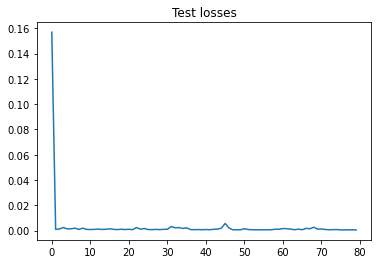

Training has finished.


In [17]:
trained_model=train_model()

## Saving the model

In [ ]:
model_number=1
base_models_path="/mnt/idms/PROJECTS/Lung/LungCT/models"
while os.path.exists(f"{base_models_path}/{model_number}.pth"):
    model_number+=1
torch.save(trained_model, f"{base_models_path}/{model_number}.pth")

## Testing

In [ ]:
average_test_loss=evaluate(trained_model,plot_result=True)

In [39]:
for param in trained_model.parameters():
    print(param.data)

tensor([[[[-0.0328,  0.0926,  0.0409,  ..., -0.0302,  0.0694, -0.0819],
          [-0.0489, -0.0259,  0.0007,  ..., -0.0859, -0.0331,  0.0446],
          [-0.1056, -0.0402, -0.0662,  ...,  0.0291,  0.0133, -0.0568],
          ...,
          [-0.0137, -0.0098, -0.0512,  ..., -0.0040,  0.0859, -0.0282],
          [-0.0980, -0.0318, -0.1011,  ...,  0.0700,  0.0283, -0.0630],
          [ 0.0214,  0.0357, -0.0219,  ..., -0.1061, -0.0088,  0.0601]]],


        [[[ 0.0251, -0.0310,  0.0073,  ...,  0.0122,  0.0179, -0.0039],
          [ 0.0812, -0.0502,  0.0733,  ...,  0.0019, -0.0797,  0.0367],
          [-0.0651,  0.0508,  0.0053,  ..., -0.1055,  0.0425,  0.0181],
          ...,
          [ 0.0416, -0.1011, -0.0248,  ...,  0.0706,  0.0927, -0.0960],
          [ 0.0380,  0.0583,  0.0417,  ..., -0.0415,  0.0653,  0.0991],
          [ 0.0190,  0.0633, -0.0693,  ...,  0.0359, -0.0435,  0.0596]]],


        [[[-0.0175, -0.0332, -0.0883,  ...,  0.0131,  0.0310, -0.0238],
          [-0.0805,  0.073